<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/recommender-systems/01_introduction.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/tutorials/blob/master/recommender-systems/01_introduction.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Introduction

In this first foray into recommender systems, we explore a popular recommendation dataset called MovieLens, studying its distributions of users, items, and ratings.  We then apply a basic yet commonly effective recommendation strategy based on item popularity.

## 1. Setup

In [1]:
!pip install --quiet cornac==2.3.2

In [2]:
import os
import sys

import cornac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, sparse

%matplotlib inline

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

System version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Cornac version: 2.3.2


## 2. Data Exploration

We begin by exploring [MovieLens](https://grouplens.org/datasets/movielens/), which is a popular benchmark dataset used in many studies on recommender systems.  There are several variants of different sizes, i.e., 100K, 1M, 10M, and 20M.  For the purpose of demonstration, we start with the smallest one with 100K ratings.  This dataset is built into and can be loaded from within the Cornac library, which also contains [other datasets](https://github.com/PreferredAI/cornac/blob/master/cornac/datasets/README.md) as well.

Most of the time we will see each instance in a recommendation dataset being represented in the form of a triplet (*user_id*, *item_id*, *rating*).  For this MovieLens dataset, the rating values are in the range {1, 2, 3, 4, 5}.

In [3]:
data = cornac.datasets.movielens.load_feedback(variant="100K")
df = pd.DataFrame(data, columns=["user_id", "item_id", "rating"])
df.head()

,user_id,item_id,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [4]:
print(f"Number of ratings: {len(df)}")
print(f"Number of users: {df.user_id.nunique()}")
print(f"Number of items: {df.item_id.nunique()}")

Number of ratings: 100000
Number of users: 943
Number of items: 1682


### Rating Statistics

Let's see some basic statistics of the rating values.

In [5]:
df.rating.describe()

,rating
count,100000.000000
mean,3.529860
std,1.125674
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


We can plot these rating values to see how it's being distributed.  

*   The 1st figure below shows a histogram of the frequency of each rating.
*   The 2nd figure describes the same distribution in the form of box plot.

Generally, more than 50% of the rating values lie between {3, 4}, rating 5 is also common, while {1, 2} are less likely.

<Axes: xlabel='rating'>

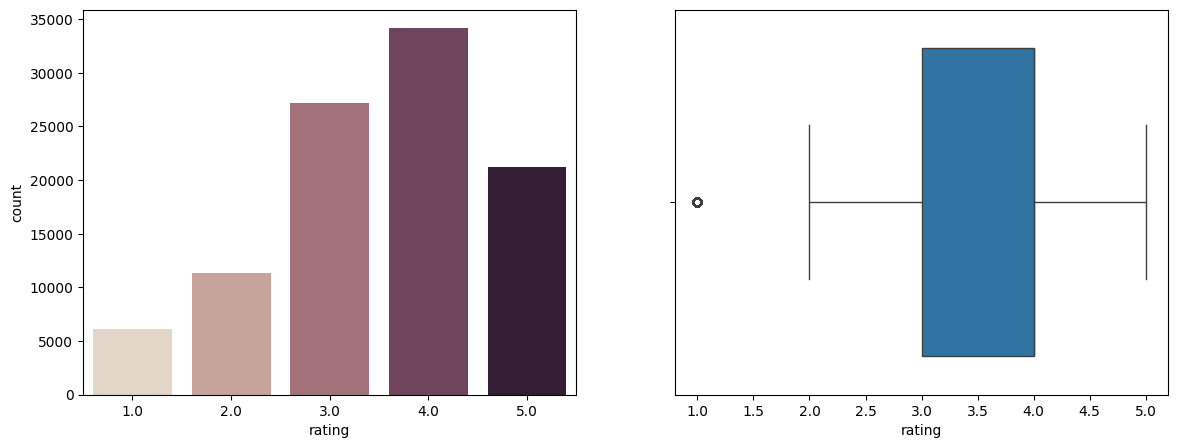

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.countplot(x="rating", hue="rating", data=df, palette="ch:.25", ax=axes[0], legend=False)
sns.boxplot(x="rating", data=df, ax=axes[1])

### Data Sparsity

Data sparsity is a measure of how much data we do *not* observe.  It is generally a challenge in learning from data.  The concern is whether we have sufficient information to build a model that can accurately capture the general distribution of the data.

For recommender systems in particular, data sparsity is expressed as the number of missing ratings divided by the total number of possible ratings.  This total is the number of users multiplied by the number of items.  In many recommendation datasets, a user only gives ratings to a limited number of items.


In [7]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()
n_ratings = len(df)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")

Number of users: 943
Number of items: 1682
Number of available ratings: 100000
Number of all possible ratings: 1586126
----------------------------------------
SPARSITY: 93.70%


For this MovieLens dataset, the data has been prepared in such a way that each user has at least 20 ratings. As a result, it's relatively dense as compared to many other recommendation datasets that are usually much sparser (often 99% or more).  

### Power-Law Distribution

In recommendation, another important phenomenom is a [power-law/long-tailed distribution](https://en.wikipedia.org/wiki/Power_law).  It implies that some of the items are very popular and frequently rated by users, while most of the other items are rated by very few users.

First, we count the number of ratings by item.  Shown below are the top 10 rated items.

In [8]:
item_rate_count = df.groupby("item_id")["user_id"].nunique().sort_values(ascending=False)
item_rate_count.head(10)

,user_id
item_id,
50,583
258,509
100,508
181,507
294,485
286,481
288,478
1,452
300,431


For contrast, let's see the list of 10 least rated items.  All of them are only rated by 1 user.

In [9]:
item_rate_count.tail(10)

,user_id
item_id,
1525,1
1661,1
1526,1
599,1
1678,1
1677,1
1679,1
1515,1
1130,1


Below we visualize the rating count information.

*   The 1st figure shows the number of ratings of each item. Items are sorted in descending values of the rating counts. Thus, the most popular item are leftmost.  The long-tailed shape discussed earlier is evident.
*   The 2nd figure is the [log-log plot](https://en.wikipedia.org/wiki/Log%E2%80%93log_plot) showing the relationship between the number of ratings and the number of items (both in log scale).   The relationship is asymptotically linear, which is the main characteristic of a power-law distribution.



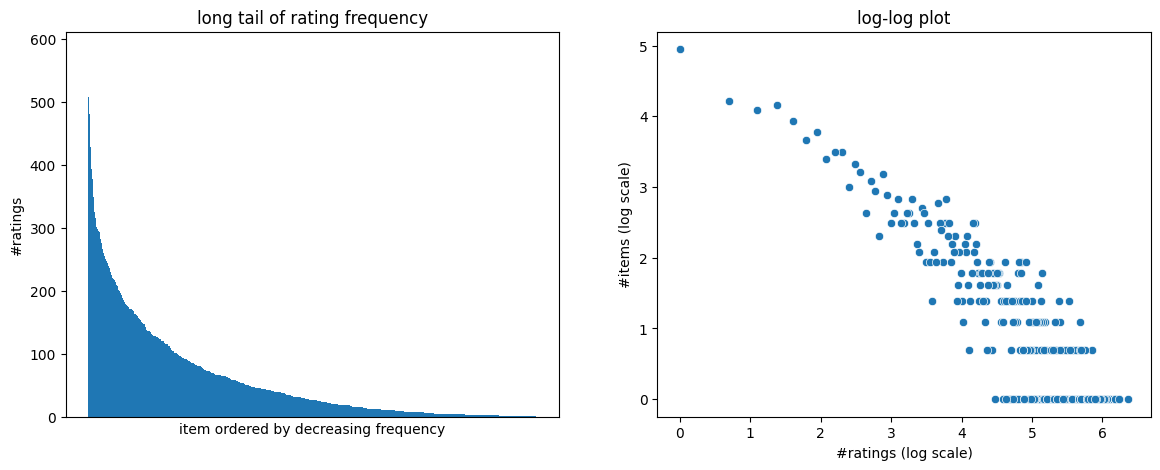

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].bar(x=item_rate_count.index, height=item_rate_count.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency",
            xlabel="item ordered by decreasing frequency",
            ylabel="#ratings")

count = item_rate_count.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");

## 3. Recommendation Based on Item Popularity

Since some items are much more popular than the rest, intuitively many users may prefer these popular items.  From that observation, it inspires a simple approach for providing recommendations based on popularity (i.e., number of ratings) of the items.   

Let's do a simple experiment with the popularity approach.  In this experiment, we will split the rating data into 5 folds for cross-validation.  For each run, 4 folds will be used for training and the remaining fold will be used for evaluation.  We measure the recommendation performance using Recall@20 metric.

In [11]:
# 5-fold cross validation
eval_method = cornac.eval_methods.CrossValidation(data, n_folds=5, seed=42)

# recommender system based on item popularity
most_pop = cornac.models.MostPop()

# recall@20 metric
rec_20 = cornac.metrics.Recall(k=20)

# put everything together into an experiment
cornac.Experiment(eval_method=eval_method, models=[most_pop], metrics=[rec_20]).run()


TEST:
...
[MostPop]
       | Recall@20 | Train (s) | Test (s)
------ + --------- + --------- + --------
Fold 0 |    0.1671 |    0.0076 |   0.9882
Fold 1 |    0.1728 |    0.0243 |   1.7007
Fold 2 |    0.1736 |    0.0078 |   0.6963
Fold 3 |    0.1652 |    0.0074 |   0.6596
Fold 4 |    0.1637 |    0.0166 |   0.8803
------ + --------- + --------- + --------
Mean   |    0.1685 |    0.0127 |   0.9850
Std    |    0.0040 |    0.0067 |   0.3775

